### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（进阶2：特征工程进阶版）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.22</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") ##忽略警告
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.metrics import confusion_matrix,recall_score, auc, roc_curve,precision_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
import math

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学） 

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据
将数据分为data_train（训练集）和 data_test（测试集）两部分。   
其中训练集占总数据量80%，即800条样本数据，测试集占20%，即200条样本数据，两个数据集均通过随机抽取得到。 

In [2]:
def data_read(data_path,file_name):
    df = pd.read_csv( os.path.join(data_path, file_name), delim_whitespace = True, header = None )
    columns = ['status_account','duration','credit_history','purpose', 'amount',
               'svaing_account', 'present_emp', 'income_rate', 'personal_status',
               'other_debtors', 'residence_info', 'property', 'age',
               'inst_plans', 'housing', 'num_credits',
               'job', 'dependents', 'telephone', 'foreign_worker', 'target']
    df.columns = columns
    # 将标签变量由状态1,2转为0,1; 其中0表示好信用，1表示坏信用
    df.target = df.target - 1
    # 将数据分为data_train（训练集）和 data_test（测试集）两部分
    # 按目标变量进行分层抽样，即训练集和测试集中，好坏样本的比例相同。
    data_train, data_test = train_test_split(df, test_size=0.2, random_state=0,stratify=df.target) 
    # 由于训练集、测试集是随机划分，索引是乱的，需要重新排序
    data_train = data_train.reset_index(drop=True)
    data_test = data_test.reset_index(drop=True)
    return data_train, data_test

if __name__ == '__main__':
    data_path = os.path.join('C:\\Users\\lotbear\\Desktop\\Data-science！','金融风控实战数据')
    file_name = 'german.csv'
    # 读取数据
    data_train, data_test = data_read(data_path,file_name)
    # 区分离散变量与连续变量
    feature_names = list(data_train.columns)
    feature_names.remove('target')
    
    data_df = pd.concat([data_train,data_test],axis=0)
    data_df = data_df.reset_index(drop=True)
    x_data = data_df.loc[:,data_df.columns != 'target']
    y_data = data_df.target
    
print('原始数据中，好信用样本量：',sum( data_df.target == 0))
print('原始数据中，坏信用样本量：',sum( data_df.target == 1))
print('原始数据总样本量：',data_df.shape)

原始数据中，好信用样本量： 700
原始数据中，坏信用样本量： 300
原始数据总样本量： (1000, 21)


### 第三步：区分离散变量 vs 连续变量，并进行变量分箱

In [3]:
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    ##先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

categorical_var,numerical_var = category_continue_separation(data_train,feature_names)

In [4]:
def func_s(x):
    return str(x[0])+'_Cross_'+str(x[1])

In [5]:
# 连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3, mmax=12,
                                     bin_rate=0.01, stop_limit=0.05, bin_min_num=20)

# 离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], 
                                     data_train.target, method=2, mmin=3,
                                     mmax=8, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)

if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]
        
print('删除分箱数只有单个的变量：','共',len(del_key),'个')
print(del_key)

### 训练集数据分箱

# 连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , 
                                   varbin_meth.cont_var_bin_map(data_train[i], 
                                   dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , 
                                   varbin_meth.disc_var_bin_map(data_train[i], 
                                   dict_disc_bin[i]) ], axis = 1)

### 测试集数据分箱
# 连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , 
                                varbin_meth.cont_var_bin_map(data_test[i], 
                                dict_cont_bin[i]) ], axis = 1)

# 离散变量分箱映射
#    ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , 
                                  varbin_meth.disc_var_bin_map(data_test[i], 
                                  dict_disc_bin[i]) ], axis = 1)

### 组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

print('='*80)
print('训练集18个变量分箱结果：')
data_train_bin

删除分箱数只有单个的变量： 共 2 个
['other_debtors', 'foreign_worker']
训练集18个变量分箱结果：


,duration_BIN,amount_BIN,income_rate_BIN,residence_info_BIN,age_BIN,num_credits_BIN,dependents_BIN,status_account_BIN,credit_history_BIN,purpose_BIN,svaing_account_BIN,present_emp_BIN,personal_status_BIN,property_BIN,inst_plans_BIN,housing_BIN,job_BIN,telephone_BIN,target
0,5,2,3,3,7,2,1,2,1,4,1,2,1,1,1,1,2,2,0
1,5,5,2,3,5,2,1,2,4,2,2,2,2,2,2,1,2,1,0
2,5,2,3,2,6,2,1,1,1,4,3,3,2,1,1,1,2,1,0
3,6,2,3,2,3,2,1,1,4,4,3,3,1,2,1,1,2,2,0
4,2,1,3,3,10,2,1,3,1,4,3,2,1,1,1,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,2,1,3,3,1,1,2,1,4,1,3,1,2,2,1,2,2,0
796,2,2,2,2,3,1,1,3,2,4,3,4,1,4,1,2,3,1,1
797,3,2,3,2,8,2,1,1,1,2,1,2,2,1,1,1,2,1,0
798,5,3,3,3,1,2,1,2,1,3,1,2,1,4,1,3,2,2,0


### 第四步：特征工程进阶——笛卡尔积
在多项式升维中，两个连续变量可以相互交叉衍生新的特征，这种特征组合的方法为笛卡尔积。   

<font color=red>举例：如果性别变量是 3 维向量，企业性质为 4 维向量，则两变量组合衍生出的笛卡尔特征为 3\*4=12 维向量。</font>   

为了避免笛卡尔积特征衍生后的维度过高，可以在变量未编码的情况下，先进行笛卡尔积的运算，将衍生出的特征向量并入原特征组合中，然后将其整体作为新的离散特征进行WOE编码。   

组合后的特征由于采用 WOE 编码，再使用 Logistic 回归模型，就可以计算出该组合下的分值，给模型提供更多的非线性特征。  

<font color=red>局限性</font>：若样本数据中并不存在一些特征的组合形式（理论上存在这种特征组合的可能性，但样本中并没有相应的数据可供学习），则模型无法学习到这种组合的权重，这个问题可在算法层的特征交叉中得到改进。

In [6]:
## 近似笛卡尔积：特征交叉
var_cross = [ 'amount_BIN', 'income_rate_BIN', 'residence_info_BIN',
       'age_BIN', 'num_credits_BIN', 'dependents_BIN', 'status_account_BIN',
       'credit_history_BIN', 'purpose_BIN', 'svaing_account_BIN',
       'present_emp_BIN', 'personal_status_BIN', 'property_BIN', 'housing_BIN', 'job_BIN']
list_name = []
for i in range(len(var_cross)-1):
    # print(var_cross[i])
    for j in range(i+1,len(var_cross)):
        # print(var_1[i]+'_Cross_'+var_1[j])
        list_name.append(var_cross[i]+'_Cross_'+var_cross[j])
        data_train_bin[var_cross[i]+'_Cross_'+var_cross[j]] = data_train_bin[[var_cross[i],var_cross[j]]].apply(func_s,axis=1)
        data_test_bin[var_cross[i]+'_Cross_'+var_cross[j]] = data_test_bin[[var_cross[i],var_cross[j]]].apply(func_s,axis=1)
print('经笛卡尔积运算后，训练集得到的衍生特征：')
data_train_bin.loc[:,list_name]

经笛卡尔积运算后，训练集得到的衍生特征：


,amount_BIN_Cross_income_rate_BIN,amount_BIN_Cross_residence_info_BIN,amount_BIN_Cross_age_BIN,amount_BIN_Cross_num_credits_BIN,amount_BIN_Cross_dependents_BIN,amount_BIN_Cross_status_account_BIN,amount_BIN_Cross_credit_history_BIN,amount_BIN_Cross_purpose_BIN,amount_BIN_Cross_svaing_account_BIN,amount_BIN_Cross_present_emp_BIN,...,present_emp_BIN_Cross_personal_status_BIN,present_emp_BIN_Cross_property_BIN,present_emp_BIN_Cross_housing_BIN,present_emp_BIN_Cross_job_BIN,personal_status_BIN_Cross_property_BIN,personal_status_BIN_Cross_housing_BIN,personal_status_BIN_Cross_job_BIN,property_BIN_Cross_housing_BIN,property_BIN_Cross_job_BIN,housing_BIN_Cross_job_BIN
0,2_Cross_3,2_Cross_3,2_Cross_7,2_Cross_2,2_Cross_1,2_Cross_2,2_Cross_1,2_Cross_4,2_Cross_1,2_Cross_2,...,2_Cross_1,2_Cross_1,2_Cross_1,2_Cross_2,1_Cross_1,1_Cross_1,1_Cross_2,1_Cross_1,1_Cross_2,1_Cross_2
1,5_Cross_2,5_Cross_3,5_Cross_5,5_Cross_2,5_Cross_1,5_Cross_2,5_Cross_4,5_Cross_2,5_Cross_2,5_Cross_2,...,2_Cross_2,2_Cross_2,2_Cross_1,2_Cross_2,2_Cross_2,2_Cross_1,2_Cross_2,2_Cross_1,2_Cross_2,1_Cross_2
2,2_Cross_3,2_Cross_2,2_Cross_6,2_Cross_2,2_Cross_1,2_Cross_1,2_Cross_1,2_Cross_4,2_Cross_3,2_Cross_3,...,3_Cross_2,3_Cross_1,3_Cross_1,3_Cross_2,2_Cross_1,2_Cross_1,2_Cross_2,1_Cross_1,1_Cross_2,1_Cross_2
3,2_Cross_3,2_Cross_2,2_Cross_3,2_Cross_2,2_Cross_1,2_Cross_1,2_Cross_4,2_Cross_4,2_Cross_3,2_Cross_3,...,3_Cross_1,3_Cross_2,3_Cross_1,3_Cross_2,1_Cross_2,1_Cross_1,1_Cross_2,2_Cross_1,2_Cross_2,1_Cross_2
4,1_Cross_3,1_Cross_3,1_Cross_10,1_Cross_2,1_Cross_1,1_Cross_3,1_Cross_1,1_Cross_4,1_Cross_3,1_Cross_2,...,2_Cross_1,2_Cross_1,2_Cross_1,2_Cross_1,1_Cross_1,1_Cross_1,1_Cross_1,1_Cross_1,1_Cross_1,1_Cross_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2_Cross_1,2_Cross_3,2_Cross_3,2_Cross_1,2_Cross_1,2_Cross_2,2_Cross_1,2_Cross_4,2_Cross_1,2_Cross_3,...,3_Cross_1,3_Cross_2,3_Cross_1,3_Cross_2,1_Cross_2,1_Cross_1,1_Cross_2,2_Cross_1,2_Cross_2,1_Cross_2
796,2_Cross_2,2_Cross_2,2_Cross_3,2_Cross_1,2_Cross_1,2_Cross_3,2_Cross_2,2_Cross_4,2_Cross_3,2_Cross_4,...,4_Cross_1,4_Cross_4,4_Cross_2,4_Cross_3,1_Cross_4,1_Cross_2,1_Cross_3,4_Cross_2,4_Cross_3,2_Cross_3
797,2_Cross_3,2_Cross_2,2_Cross_8,2_Cross_2,2_Cross_1,2_Cross_1,2_Cross_1,2_Cross_2,2_Cross_1,2_Cross_2,...,2_Cross_2,2_Cross_1,2_Cross_1,2_Cross_2,2_Cross_1,2_Cross_1,2_Cross_2,1_Cross_1,1_Cross_2,1_Cross_2
798,3_Cross_3,3_Cross_3,3_Cross_1,3_Cross_2,3_Cross_1,3_Cross_2,3_Cross_1,3_Cross_3,3_Cross_1,3_Cross_2,...,2_Cross_1,2_Cross_4,2_Cross_3,2_Cross_2,1_Cross_4,1_Cross_3,1_Cross_2,4_Cross_3,4_Cross_2,3_Cross_2


In [7]:
## WOE编码
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')
    
## 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,
                                                                                 data_path,var_all_bin,
                                                                                 data_train_bin.target,
                                                                                 'dict_woe_map', flag='train')  
## 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,
                                                  data_path,var_all_bin, 
                                                  data_test_bin.target, 
                                                  'dict_woe_map',flag='test')
print('训练集衍生得到的特征向量，WOE编码结果：')
df_train_woe.iloc[:,142:]

训练集衍生得到的特征向量，WOE编码结果：


,amount_BIN_Cross_income_rate_BIN_woe,amount_BIN_Cross_residence_info_BIN_woe,amount_BIN_Cross_age_BIN_woe,amount_BIN_Cross_num_credits_BIN_woe,amount_BIN_Cross_dependents_BIN_woe,amount_BIN_Cross_status_account_BIN_woe,amount_BIN_Cross_credit_history_BIN_woe,amount_BIN_Cross_purpose_BIN_woe,amount_BIN_Cross_svaing_account_BIN_woe,amount_BIN_Cross_present_emp_BIN_woe,...,present_emp_BIN_Cross_personal_status_BIN_woe,present_emp_BIN_Cross_property_BIN_woe,present_emp_BIN_Cross_housing_BIN_woe,present_emp_BIN_Cross_job_BIN_woe,personal_status_BIN_Cross_property_BIN_woe,personal_status_BIN_Cross_housing_BIN_woe,personal_status_BIN_Cross_job_BIN_woe,property_BIN_Cross_housing_BIN_woe,property_BIN_Cross_job_BIN_woe,housing_BIN_Cross_job_BIN_woe
0,-0.162945,-0.293426,-1.009000,-0.260048,-0.224557,0.068993,-1.090644,0.144934,-0.808660,-0.569768,...,-0.287682,-1.024504,-0.556091,-0.353444,-0.890973,-0.341171,-0.166757,-0.642793,-0.469317,-0.251314
1,-7.130899,-0.538997,-6.571283,-0.164303,-0.376478,-1.232144,0.847298,-0.356675,-5.878136,-0.538997,...,-0.141314,-0.369097,-0.556091,-0.353444,0.190518,0.040822,0.187157,-0.141695,-0.160660,-0.251314
2,-0.162945,-0.242265,0.113329,-0.260048,-0.224557,-1.460827,-1.090644,0.144934,-0.013356,-0.306665,...,0.107631,-0.500775,-0.131297,-0.020566,-0.204247,0.040822,0.187157,-0.642793,-0.469317,-0.251314
3,-0.162945,-0.242265,-0.481838,-0.260048,-0.224557,-1.460827,1.115562,0.144934,-0.013356,-0.306665,...,-0.114113,0.137621,-0.131297,-0.020566,-0.145954,-0.341171,-0.166757,-0.141695,-0.160660,-0.251314
4,0.775839,0.303682,-0.331357,-1.292768,0.241162,1.358123,-1.292768,0.713766,0.504353,0.020619,...,-0.287682,-1.024504,-0.556091,-0.331357,-0.890973,-0.341171,-0.220543,-0.642793,-0.688032,-0.378654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.409785,-0.293426,-0.481838,-0.199355,-0.224557,0.068993,-1.090644,0.144934,-0.808660,-0.306665,...,-0.114113,0.137621,-0.131297,-0.020566,-0.145954,-0.341171,-0.166757,-0.141695,-0.160660,-0.251314
796,-0.270733,-0.242265,-0.481838,-0.199355,-0.224557,0.545822,-0.195885,0.144934,-0.013356,0.409043,...,0.200671,0.205444,-0.405465,0.377294,0.330607,0.218689,-0.156004,0.263350,0.190518,-0.451985
797,-0.162945,-0.242265,-0.315853,-0.260048,-0.224557,-1.460827,-1.090644,-0.957201,-0.808660,-0.569768,...,-0.141314,-1.024504,-0.556091,-0.353444,-0.204247,0.040822,0.187157,-0.642793,-0.469317,-0.251314
798,0.000000,-0.693147,-1.232144,-0.944462,-0.790311,-0.762140,-1.167605,-0.944462,-1.860752,-0.451985,...,-0.287682,0.409043,0.479573,-0.353444,0.330607,0.324050,-0.166757,0.847298,0.429563,0.639658


In [8]:
## 取出训练数据与测试数据
x_train = df_train_woe[var_woe_name]
x_train = np.array(x_train)
y_train = np.array(df_train_woe.target)

del_list = []
for s in var_woe_name:
    index_s = df_test_woe[s].isnull()
    if sum(index_s)> 0:
        del_list.extend(list(df_test_woe.index[index_s]))
if len(del_list)>0:
    list_1 = [x for x in list(df_test_woe.index) if x not in del_list ]
    df_test_woe = df_test_woe.loc[list_1]
        
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target.loc[list_1])
else:
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target)

In [9]:
## logistic 逻辑回归模型拟合
## 设置待优化的超参数
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]}
    
## 初始化网格搜索
lr_gsearch = GridSearchCV(
    estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
    param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)

## 执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('LR逻辑回归模型最优得分 {0},\n最优参数{1}'.format(lr_gsearch.best_score_,lr_gsearch.best_params_))

## 用最优参数，初始化logistic模型
LR_model_2 = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                    class_weight=lr_gsearch.best_params_['class_weight'])
## 训练logistic模型
LR_model_fit = LR_model_2.fit(x_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    5.0s finished


LR逻辑回归模型最优得分 0.722225061941374,
最优参数{'C': 0.2, 'class_weight': {1: 3, 0: 1}}


In [10]:
## 模型预测
y_pred = LR_model_fit.predict(x_test)
print('用训练好的LR模型，对测试集target数据进行预测：','\n','target=0 为好信用，target=1 为坏信用')
print('='*80)
print(y_pred)
print('='*80)
print('测试集中，坏信用数量:',sum(y_pred==1))
print('测试集中，好信用数量:',sum(y_pred==0))
print('测试集总样本量:',len(y_pred))

用训练好的LR模型，对测试集target数据进行预测： 
 target=0 为好信用，target=1 为坏信用
[0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1
 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1
 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1
 0 0 0 0 1 0 0]
测试集中，坏信用数量: 73
测试集中，好信用数量: 119
测试集总样本量: 192


In [11]:
## 计算混淆矩阵cnf_matrix、召回率recall、精准率precision、模型预测的准确率accuracy_score

cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('LR模型的召回率：',recall_value)
print('LR模型的精准率：',precision_value)
print('LR模型预测的正确率:',acc)
print('='*80)
print('测试集的混淆矩阵：')
cnf_matrix

LR模型的召回率： 0.6428571428571429
LR模型的精准率： 0.4931506849315068
LR模型预测的正确率: 0.703125
测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,99,37
真实样本为反例,20,36


In [12]:
## 计算fpr与tpr
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
    
## 计算AR、gini等
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
gini = ar
print('测试集的 AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)
print('测试集的AUC值为:',roc_auc)

测试集的 AR/基尼系数为: 0.48398109243697474
测试集的KS值为: 0.41911764705882354
测试集的AUC值为: 0.7419905462184874


最大KS值: 0.41911764705882354


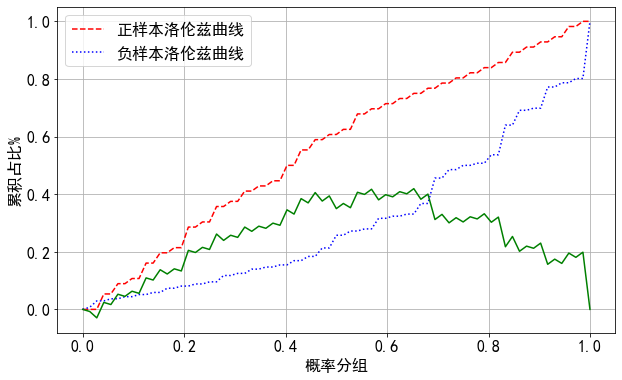

In [13]:
## ks曲线    
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
print('最大KS值:',max(tpr - fpr))

### 第五步：特征工程进阶——基于树模型的特征生成：GBDT梯度下降树
GBDT 模型采样串行的集成策略得到集成模型，将负梯度方向的值作为新的标签，并在下一轮模型拟合时，更加关注那些被错误分类的样本，最后将多个训练轮次得到的决策树通过线性加权的方式进行组合，得到 GBDT 模型。  

实际应用中，用 GBDT 模型做特征衍生较为常见，通过改变决策树的深度，就可以得到高维笛卡尔积特征交叉的效果。

In [14]:
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

## WOE编码
var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')
    
## 训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,
                                                                                 data_path,var_all_bin,
                                                                                 data_train_bin.target,
                                                                                 'dict_woe_map', flag='train')  
## 测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,
                                                  data_path,var_all_bin, 
                                                  data_test_bin.target, 
                                                  'dict_woe_map',flag='test')
print('训练集特征向量，WOE编码结果：')
df_train_woe.loc[:,var_woe_name]

训练集特征向量，WOE编码结果：


,duration_BIN_woe,amount_BIN_woe,income_rate_BIN_woe,residence_info_BIN_woe,age_BIN_woe,num_credits_BIN_woe,dependents_BIN_woe,status_account_BIN_woe,credit_history_BIN_woe,purpose_BIN_woe,svaing_account_BIN_woe,present_emp_BIN_woe,personal_status_BIN_woe,property_BIN_woe,inst_plans_BIN_woe,housing_BIN_woe,job_BIN_woe,telephone_BIN_woe
0,-0.010152,-0.254159,0.122148,-0.047553,-0.762140,-0.074242,0.01138,0.301308,-0.824988,0.393733,-0.730888,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.001890,0.090026
1,-0.010152,-0.538997,-0.041594,-0.047553,-0.123481,-0.074242,0.01138,0.301308,1.326871,-0.656780,0.135802,-0.244884,0.204582,0.012270,0.534206,-0.171998,-0.001890,-0.136336
2,-0.010152,-0.254159,0.122148,0.098752,0.211309,-0.074242,0.01138,-1.138115,-0.824988,0.393733,0.250611,-0.005277,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336
3,0.746493,-0.254159,0.122148,0.098752,-0.060259,-0.074242,0.01138,-1.138115,1.326871,0.393733,0.250611,-0.005277,-0.175031,0.012270,-0.151537,-0.171998,-0.001890,0.090026
4,-0.762140,0.431137,0.122148,-0.047553,-0.370098,-0.074242,0.01138,0.792238,-0.824988,0.393733,0.250611,-0.244884,-0.175031,-0.505095,-0.151537,-0.171998,-0.136434,0.090026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.311939,-0.254159,-0.145954,-0.047553,-0.060259,0.057690,0.01138,0.301308,-0.824988,0.393733,-0.730888,-0.005277,-0.175031,0.012270,0.534206,-0.171998,-0.001890,0.090026
796,-0.762140,-0.254159,-0.041594,0.098752,-0.060259,0.057690,0.01138,0.792238,0.089612,0.393733,0.250611,0.486683,-0.175031,0.448659,-0.151537,0.292301,0.154151,-0.136336
797,-0.311939,-0.254159,0.122148,0.098752,-0.405465,-0.074242,0.01138,-1.138115,-0.824988,-0.656780,-0.730888,-0.244884,0.204582,-0.505095,-0.151537,-0.171998,-0.001890,-0.136336
798,-0.010152,-0.604954,0.122148,-0.047553,0.441833,-0.074242,0.01138,0.301308,-0.824988,0.017575,-0.730888,-0.244884,-0.175031,0.448659,-0.151537,0.465930,-0.001890,0.090026


In [15]:
## 取出训练数据与测试数据
x_train = df_train_woe[var_woe_name]
x_train = np.array(x_train)
y_train = np.array(data_train_bin.target)
    
x_test = df_test_woe[var_woe_name]
x_test = np.array(x_test)
y_test = np.array(data_test_bin.target)

In [16]:
## GBDT模型
GBDT_model= GradientBoostingClassifier(subsample=0.8,max_features=0.8, validation_fraction=0.1, 
                                    n_iter_no_change =3,random_state=0,n_estimators=20,
                                     max_depth=2,learning_rate=0.1)
## 训练GBDT模型
GBDT_model_fit = GBDT_model.fit(x_train, y_train)
    
## 用apply方法得到树的映射结果
train_new_feature= GBDT_model_fit.apply(x_train)[:, :, 0]
test_new_feature= GBDT_model_fit.apply(x_test)[:, :, 0]
np.unique(train_new_feature[:,1])

array([2., 3., 5., 6.])

In [17]:
## 进行One-hot编码
enc = OneHotEncoder(dtype='int').fit(train_new_feature)
df_train = pd.DataFrame( enc.transform(train_new_feature).toarray())
df_test = pd.DataFrame( enc.transform(test_new_feature).toarray())
    
## 合并得到新的数据集
x_train_1 = np.hstack([x_train,df_train])
x_test_1 = np.hstack([x_test,df_test])

print('训练集中，GBDT衍生出的新变量：')
df_train

训练集中，GBDT衍生出的新变量：


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
796,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
797,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
798,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [18]:
## logistic 逻辑回归模型拟合
## 设置待优化的超参数
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1}, {1: 2, 0: 1}, {1: 3, 0: 1}]}
    
## 初始化网格搜索
lr_gsearch = GridSearchCV(
    estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
    param_grid=lr_param, cv=3, scoring='f1', n_jobs=-1, verbose=2)

## 执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('LR逻辑回归模型最优得分 {0},\n最优参数{1}'.format(lr_gsearch.best_score_,lr_gsearch.best_params_))

## 用最优参数，初始化logistic模型
LR_model_2 = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                    class_weight=lr_gsearch.best_params_['class_weight'])
## 训练logistic模型
LR_model_fit = LR_model_2.fit(x_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


LR逻辑回归模型最优得分 0.6524763188305204,
最优参数{'C': 1, 'class_weight': {1: 3, 0: 1}}


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    0.1s finished


In [19]:
## 模型预测
y_pred = LR_model_fit.predict(x_test)
print('用训练好的LR模型，对测试集target数据进行预测：','\n','target=0 为好信用，target=1 为坏信用')
print('='*80)
print(y_pred)
print('='*80)
print('测试集中，坏信用数量:',sum(y_pred==1))
print('测试集中，好信用数量:',sum(y_pred==0))
print('测试集总样本量:',len(y_pred))

用训练好的LR模型，对测试集target数据进行预测： 
 target=0 为好信用，target=1 为坏信用
[1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0]
测试集中，坏信用数量: 88
测试集中，好信用数量: 112
测试集总样本量: 200


In [20]:
## 计算混淆矩阵cnf_matrix、召回率recall、精准率precision、模型预测的准确率accuracy_score

cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('LR模型的召回率：',recall_value)
print('LR模型的精准率：',precision_value)
print('LR模型预测的正确率:',acc)
print('='*80)
print('测试集的混淆矩阵：')
cnf_matrix

LR模型的召回率： 0.7333333333333333
LR模型的精准率： 0.5
LR模型预测的正确率: 0.7
测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,96,44
真实样本为反例,16,44


In [21]:
## 计算fpr与tpr
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
    
## 计算AR、gini等
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
gini = ar
print('测试集的 AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)
print('测试集的AUC值为:',roc_auc)

测试集的 AR/基尼系数为: 0.5404761904761906
测试集的KS值为: 0.44999999999999996
测试集的AUC值为: 0.7702380952380953


最大KS值: 0.44999999999999996


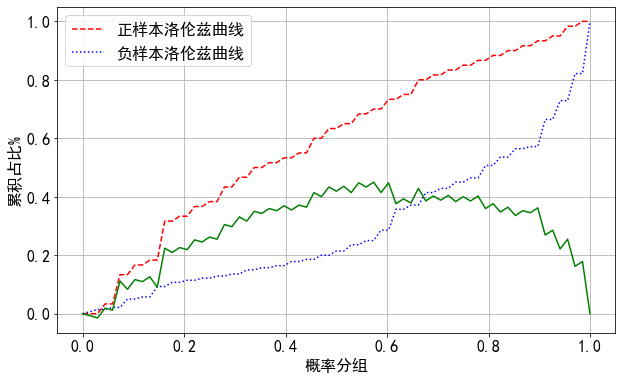

In [22]:
## ks曲线    
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
print('最大KS值:',max(tpr - fpr))

### 第六步：特征工程进阶—— FM 因子机特征交叉（隐向量点积）
Factorization Machine 因子机模型可以组合任意高阶特征，用隐向量点积作为特征交叉组合的权重，且隐向量的学习只与变量自身有关，这就避免了特征稀疏情况下无法有效学习权重矩阵的问题。   

FM 模型是一种有效的低维特征组合方法，是线性回归模型的一种拓展，即增加了二阶交叉项，又是多项式模型的一种改进，即用隐向量的形式近似计算交叉项权重，FM 的求解依然可以采用梯度下降的方法实现。  

由于 FM 模型可以直接对 One-hot 编码后的离散变量进行特征交叉，因此本例的处理方式为：将离散变量直接进行 One-hot 编码，连续变量只做缺失值添补并归一化处理，然后与编码后的离散变量一起参与特征交叉建模。（即：对连续变量不再进行‘分箱+WOE编码’操作）

In [23]:
## 连续变量缺失值做填补
for i in numerical_var:
    if sum(data_train[i].isnull()) >0:
        data_train[i].fillna(data_train[i].mean(),inplace=True)
            
## 变量归一化
scaler = StandardScaler().fit(data_train[numerical_var])
data_train[numerical_var] = scaler.transform(data_train[numerical_var])  
data_test[numerical_var] = scaler.transform(data_test[numerical_var])

print('连续变量去量纲前(原数据)：')
data_df[numerical_var]

连续变量去量纲前(原数据)：


,duration,amount,income_rate,residence_info,age,num_credits,dependents
0,30,2181,4,4,36,2,1
1,20,6148,3,4,31,2,1
2,24,2058,4,2,33,2,1
3,36,2613,4,2,27,2,1
4,8,731,4,4,47,2,1
...,...,...,...,...,...,...,...
995,12,6078,2,2,32,1,1
996,18,5866,2,2,30,2,1
997,36,15857,2,3,43,1,1
998,24,1275,2,4,36,2,1


In [24]:
print('连续变量去量纲后（归一化）：')
data_train[numerical_var]

连续变量去量纲后（归一化）：


,duration,amount,income_rate,residence_info,age,num_credits,dependents
0,0.754215,-0.379305,0.925948,1.045269,0.021988,1.015220,-0.444528
1,-0.089898,1.060270,0.032391,1.045269,-0.413415,1.015220,-0.444528
2,0.247747,-0.423940,0.925948,-0.784523,-0.239254,1.015220,-0.444528
3,1.260682,-0.222538,0.925948,-0.784523,-0.761737,1.015220,-0.444528
4,-1.102833,-0.905492,0.925948,1.045269,0.979873,1.015220,-0.444528
...,...,...,...,...,...,...,...
795,-0.511954,-0.326686,-0.861166,1.045269,-0.761737,-0.701854,-0.444528
796,-1.018422,-0.654737,0.032391,-0.784523,-0.761737,-0.701854,-0.444528
797,-0.765188,-0.720782,0.925948,-0.784523,0.196149,1.015220,-0.444528
798,0.247747,0.141801,0.925948,1.045269,-1.371300,1.015220,-0.444528


In [25]:
## 取出训练数据与测试数据
var_all = list(data_train.columns)
var_all.remove('target')
df_all = pd.concat([data_train,data_test],axis=0)

## df转为字典
df_all =  df_all[var_all].to_dict(orient='records')
x_train =  data_train[var_all].to_dict(orient='records')
x_test =  data_test[var_all].to_dict(orient='records')

print('训练集数据，按标签转为字典数据：(显示一条字典映射，共800条)')
x_train[0]

训练集数据，按标签转为字典数据：(显示一条字典映射，共800条)


{'status_account': 'A12',
 'duration': 0.7542145133976272,
 'credit_history': 'A34',
 'purpose': 'A40',
 'amount': -0.379305038104254,
 'svaing_account': 'A65',
 'present_emp': 'A75',
 'income_rate': 0.9259483948294617,
 'personal_status': 'A93',
 'other_debtors': 'A101',
 'residence_info': 1.0452686206020596,
 'property': 'A121',
 'age': 0.021987822110272844,
 'inst_plans': 'A143',
 'housing': 'A152',
 'num_credits': 1.015220169280132,
 'job': 'A173',
 'dependents': -0.4445276036638914,
 'telephone': 'A191',
 'foreign_worker': 'A201'}

In [26]:
## 字典转为稀疏矩阵
model_dictV = DictVectorizer().fit(df_all)
x_train = model_dictV.fit_transform(x_train)
x_test = model_dictV.transform(x_test)

print('再将字典数据转为稀疏矩阵(显示一行系数矩阵，共800行)：')
print(x_train[0])
print('稀疏矩阵总数据量：',x_train.shape)

再将字典数据转为稀疏矩阵(显示一行系数矩阵，共800行)：
  (0, 0)	0.021987822110272844
  (0, 1)	-0.379305038104254
  (0, 6)	1.0
  (0, 7)	-0.4445276036638914
  (0, 8)	0.7542145133976272
  (0, 9)	1.0
  (0, 12)	1.0
  (0, 14)	0.9259483948294617
  (0, 17)	1.0
  (0, 20)	1.0
  (0, 22)	1.015220169280132
  (0, 23)	1.0
  (0, 28)	1.0
  (0, 34)	1.0
  (0, 35)	1.0
  (0, 39)	1.0
  (0, 49)	1.0452686206020596
  (0, 51)	1.0
  (0, 58)	1.0
  (0, 59)	1.0
稀疏矩阵总数据量： (800, 61)


In [27]:
y_train = np.array(data_train.target)
y_test = np.array(data_test.target)

In [28]:
## 查看系数矩阵的内容
st = x_test.toarray()
    
fm = pylibfm.FM(num_factors=5, num_iter=500, verbose=True, task="classification",
                initial_learning_rate=0.0001, learning_rate_schedule="optimal")

fm.fit(x_train,y_train)

In [31]:
## 模型预测
y_score_test = fm.predict(x_test)
y_pred = [1 if x >=0.5 else 0 for x in y_score_test ]
y_pred = np.array(list(map(int, y_pred)))

print('测试集经 FM 模型预测后吗，得到的分类结果：')
print('='*80)
print(y_pred)
print('='*80)
print('测试集中，坏信用数量:',sum(y_pred==1))
print('测试集中，好信用数量:',sum(y_pred==0))
print('测试集总样本量:',len(y_pred))

测试集经 FM 模型预测后吗，得到的分类结果：
[0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0]
测试集中，坏信用数量: 42
测试集中，好信用数量: 158
测试集总样本量: 200


In [32]:
## 计算混淆矩阵cnf_matrix、召回率recall、精准率precision、模型预测的准确率accuracy_score

cnf_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                          columns=['预测结果为正例','预测结果为反例'],index=['真实样本为正例','真实样本为反例'])
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('LR模型的召回率：',recall_value)
print('LR模型的精准率：',precision_value)
print('LR模型预测的正确率:',acc)
print('='*80)
print('测试集的混淆矩阵：')
cnf_matrix

LR模型的召回率： 0.43333333333333335
LR模型的精准率： 0.6190476190476191
LR模型预测的正确率: 0.75
测试集的混淆矩阵：


,预测结果为正例,预测结果为反例
真实样本为正例,124,16
真实样本为反例,34,26


In [33]:
## 计算fpr与tpr
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
    
## 计算AR、gini等
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
gini = ar
print('测试集的 AR/基尼系数为:',ar)
print('测试集的KS值为:',ks)
print('测试集的AUC值为:',roc_auc)

测试集的 AR/基尼系数为: 0.5738095238095238
测试集的KS值为: 0.5142857142857142
测试集的AUC值为: 0.7869047619047619


最大KS值: 0.5142857142857142


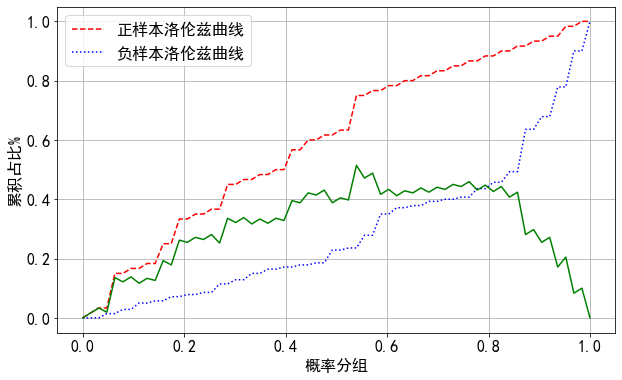

In [34]:
## ks曲线    
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='red', label='正样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='blue', label='负样本洛伦兹曲线')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='green')
plt.grid()
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('概率分组',fontsize=16)
plt.ylabel('累积占比%',fontsize=16)
plt.legend(fontsize=16)
print('最大KS值:',max(tpr - fpr))